In [8]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [2]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 100
Número de ecgs que eram pra ser processados: 100
Número total de traçados processados: 100


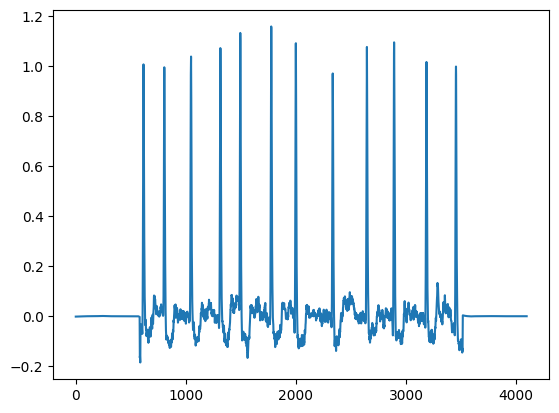

In [31]:
X = carregar_ecgs(normal=0,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=100,filtrado=True)

plt.plot(X[0][0])

In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score

# Lista de classes
classes = ['umdavb', 'rbbb', 'lbbb', 'sb', 'st', 'af', 'normal']
num_classes = len(classes)

class GATResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.5):
        super(GATResidualBlock, self).__init__()
        self.conv = GATConv(in_channels, out_channels, heads=heads, dropout=dropout, concat=True)
        self.bn = torch.nn.BatchNorm1d(out_channels * heads)
        self.res_lin = torch.nn.Linear(in_channels, out_channels * heads) if in_channels != out_channels * heads else None
        self.dropout = dropout

    def forward(self, x, edge_index):
        # x_in para residual connection
        x_in = x
        x = self.conv(x, edge_index)
        x = self.bn(x)
        x = F.relu(x)

        # Residual connection: se necessário, projeta x_in para o tamanho de x
        if self.res_lin is not None:
            x_in = self.res_lin(x_in)

        x = x + x_in
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

class GATGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5, heads=4):
        super(GATGraphClassifier, self).__init__()
        # Aumento da profundidade usando blocos GAT residuais
        # Primeiro bloco: projeta de num_features para hidden_dim
        self.block1 = GATResidualBlock(num_features, hidden_dim, heads=heads, dropout=dropout)
        # Segundo bloco
        self.block2 = GATResidualBlock(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        # Terceiro bloco
        self.block3 = GATResidualBlock(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)

        # MLP final após o pooling
        self.lin1 = torch.nn.Linear(hidden_dim * heads, hidden_dim * 2)
        self.bn_mlp = torch.nn.BatchNorm1d(hidden_dim * 2)
        self.lin2 = torch.nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)
        x = self.block3(x, edge_index)

        # Pooling global
        x = global_mean_pool(x, batch)

        # MLP final
        x = self.lin1(x)
        x = self.bn_mlp(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x


def train(loader, model, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # shape: [batch_size, num_classes]
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(loader, model, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)  # [batch_size, num_classes]
            pred = torch.argmax(out, dim=1)  # classe predita
            true = batch.y  # classe verdadeira
            preds.append(pred.cpu())
            trues.append(true.cpu())
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    acc = (preds == trues).mean()
    f1 = f1_score(trues, preds, average='macro')
    return acc, f1

if __name__ == "__main__":
    # Arquivos por classe (um arquivo .pt por classe)
    class_files = [
        'umdavb.pt',
        'rbbb.pt',
        'lbbb.pt',
        'sb.pt',
        'st.pt',
        'af.pt',
        'normais.pt'
    ]

    class ECGVisibilityGraphsDataset(InMemoryDataset):
        def __init__(self, root, class_files, classes, transform=None, pre_transform=None):
            self.class_files = class_files
            self.classes = classes
            self._num_classes = len(classes)
            super(ECGVisibilityGraphsDataset, self).__init__(root, transform, pre_transform)
            self.data, self.slices = torch.load(self.processed_paths[0])

        @property
        def processed_file_names(self):
            return ['data.pt']

        def process(self):
            data_list = []
            for i, pt_path in enumerate(self.class_files):
                saved_data = torch.load(pt_path)
                grafos = saved_data['grafos']
                for g in grafos:
                    src = g['src']
                    dst = g['dst']
                    num_nodes = max(src.max().item(), dst.max().item()) + 1
                    F_dim = 16
                    x = torch.ones((num_nodes, F_dim), dtype=torch.float)
                    edge_index = torch.stack([src, dst], dim=0)

                    y = torch.tensor(i, dtype=torch.long)
                    data = Data(x=x, edge_index=edge_index, y=y)
                    data_list.append(data)

            if self.pre_filter is not None:
                data_list = [d for d in data_list if self.pre_filter(d)]

            if self.pre_transform is not None:
                data_list = [self.pre_transform(d) for d in data_list]

            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

    dataset = ECGVisibilityGraphsDataset(root='.', class_files=class_files, classes=classes)
    dataset = dataset.shuffle()
    n = len(dataset)
    train_len = int(0.8 * n)
    val_len = int(0.1 * n)
    test_len = n - train_len - val_len

    train_dataset = dataset[:train_len]
    val_dataset = dataset[train_len:train_len+val_len]
    test_dataset = dataset[train_len+val_len:]

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Aumento de complexidade do modelo:
    # - heads=4 para multi-cabeças de atenção
    # - hidden_dim=64 para maior capacidade
    # - dropout=0.5 já definido
    model = GATGraphClassifier(num_features=16, hidden_dim=64, num_classes=num_classes, dropout=0.5, heads=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Treinando por mais épocas
    for epoch in range(200):
        loss = train(train_loader, model, optimizer, criterion, device)
        if epoch % 20 == 0:
            val_acc, val_f1 = evaluate(val_loader, model, device)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

    test_acc, test_f1 = evaluate(test_loader, model, device)
    print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

    # Salvar o modelo
    torch.save(model.state_dict(), "modelo_treinado.pt")


/tmp/ipykernel_831179/3897941791.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Epoch 0: Loss = 2.1841, Val Acc = 0.1143, Val F1 = 0.0293
Epoch 20: Loss = 1.9224, Val Acc = 0.2286, Val F1 = 0.0532
Epoch 40: Loss = 1.9381, Val Acc = 0.2286, Val F1 = 0.0532
Epoch 60: Loss = 1.9348, Val Acc = 0.2286, Val F1 = 0.0532


KeyboardInterrupt: 